In [73]:
# PROJECT 2: Optimizing Loan Approval Predictions: A Comprehensive Machine Learning Analysis

#ploting libraries
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

#relevant ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer


# Load the datasets
train_df = pd.read_csv(r"C:\Users\adria\OneDrive\Documents\train_loan.csv")  # Replace with your actual file path
test_df = pd.read_csv(r"C:\Users\adria\OneDrive\Documents\test_loan.csv")    # Replace with your actual file path

# Display the first few rows of each dataset
print("Training Data:")
print(train_df.head())
print("\nTesting Data:")
print(test_df.head())


#Preprocessing Data

#the Id column is not needed, let's drop it for both test and train datasets

train_df.drop('Loan_ID',axis=1,inplace=True)
test_df.drop('Loan_ID',axis=1,inplace=True)
#checking the new shapes
print(f"training set (row, col): {train_df.shape}\n\ntesting set (row, col): {test_df.shape}")

# Show the count of missing values in each column for both datasets
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())
print("\nMissing Values in Testing Data:")
print(test_df.isnull().sum())

Training Data:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2    

In [74]:
# Handle missing values
# For simplicity, the missing values were filled with the mean for numerical features and the mode for categorical features.
# This can be adjusted based on the dataset specifics.

# Handle missing values in training data
numerical_features = ['LoanAmount', 'ApplicantIncome']  # Adjust based on your dataset
train_df[numerical_features] = train_df[numerical_features].fillna(train_df[numerical_features].mean())

categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']  # Adjust based on your dataset
for feature in categorical_features:
    train_df[feature] = train_df[feature].fillna(train_df[feature].mode()[0])

# Handle remaining missing values
train_df['Loan_Amount_Term'] = train_df['Loan_Amount_Term'].fillna(train_df['Loan_Amount_Term'].mode()[0])
train_df['Credit_History'] = train_df['Credit_History'].fillna(train_df['Credit_History'].mode()[0])

# Handle missing values in testing data
test_df[numerical_features] = test_df[numerical_features].fillna(test_df[numerical_features].mean())
for feature in categorical_features:
    test_df[feature] = test_df[feature].fillna(test_df[feature].mode()[0])

# Handle remaining missing values
test_df['Loan_Amount_Term'] = test_df['Loan_Amount_Term'].fillna(test_df['Loan_Amount_Term'].mode()[0])
test_df['Credit_History'] = test_df['Credit_History'].fillna(test_df['Credit_History'].mode()[0])

# Verify that there are no missing values left
print("\nMissing Values After Imputation in Training Data:")
print(train_df.isnull().sum())
print("\nMissing Values After Imputation in Testing Data:")
print(test_df.isnull().sum())



Missing Values After Imputation in Training Data:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Missing Values After Imputation in Testing Data:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


In [75]:
#summary of the missing data
print("Before filling missing values\n\n","#"*50,"\n")
null_cols = ['Credit_History', 'Self_Employed', 'LoanAmount','Dependents', 'Loan_Amount_Term', 'Gender', 'Married']


for col in null_cols:
    print(f"{col}:\n{train_df[col].value_counts()}\n","-"*50)
    train_df[col] = train_df[col].fillna(
    train_df[col].dropna().mode().values[0] )   

    
train_df.isnull().sum().sort_values(ascending=False)
print("After filling missing values\n\n","#"*50,"\n")
for col in null_cols:
    print(f"\n{col}:\n{train_df[col].value_counts()}\n","-"*50)

Before filling missing values

 ################################################## 

Credit_History:
Credit_History
1.0    525
0.0     89
Name: count, dtype: int64
 --------------------------------------------------
Self_Employed:
Self_Employed
No     532
Yes     82
Name: count, dtype: int64
 --------------------------------------------------
LoanAmount:
LoanAmount
146.412162    22
120.000000    20
110.000000    17
100.000000    15
160.000000    12
              ..
240.000000     1
214.000000     1
59.000000      1
166.000000     1
253.000000     1
Name: count, Length: 204, dtype: int64
 --------------------------------------------------
Dependents:
Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64
 --------------------------------------------------
Loan_Amount_Term:
Loan_Amount_Term
360.0    526
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64
 ---------------------

In [76]:
#list of all the columns.columns
#Cols = train_df.tolist()
#list of all the numeric columns
num = train_df.select_dtypes('number').columns.to_list()
#list of all the categoric columns
cat = train_df.select_dtypes('object').columns.to_list()

#numeric df
loan_num =  train_df[num]
#categoric df
loan_cat = train_df[cat]

C:\Users\adria\AppData\Local\Temp\ipykernel_29324\4118551193.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=train_df[loan_status_col], palette="pastel")


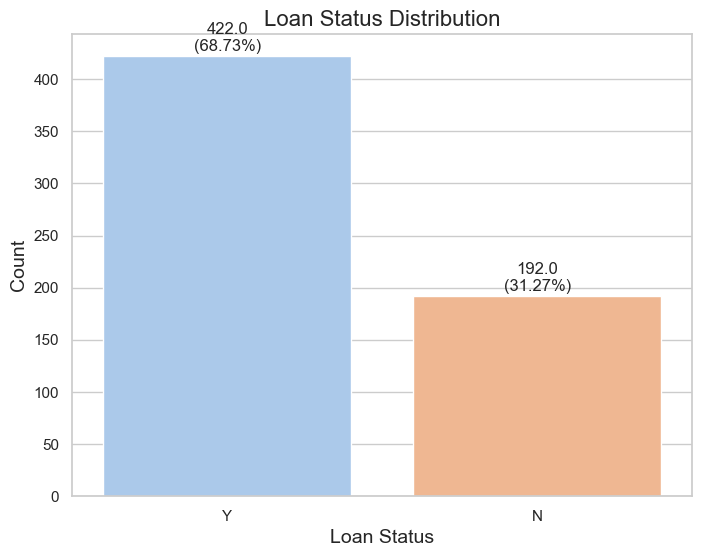

In [79]:
# Data Visualization
# Directly reference the Loan_Status column for visualization
loan_status_col = 'Loan_Status_Y' if 'Loan_Status_Y' in train_df.columns else 'Loan_Status'

# Print value counts of the target variable
loan_status_counts = train_df[loan_status_col].value_counts()

# Visualize the distribution of the target variable
total = float(len(train_df[loan_status_col]))
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")

ax = sns.countplot(x=train_df[loan_status_col], palette="pastel")
ax.set_title("Loan Status Distribution", fontsize=16)
ax.set_xlabel("Loan Status", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

# Display the count and percentage on each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{height}\n({height/total:.2%})', ha="center")

# Show plot
plt.show()


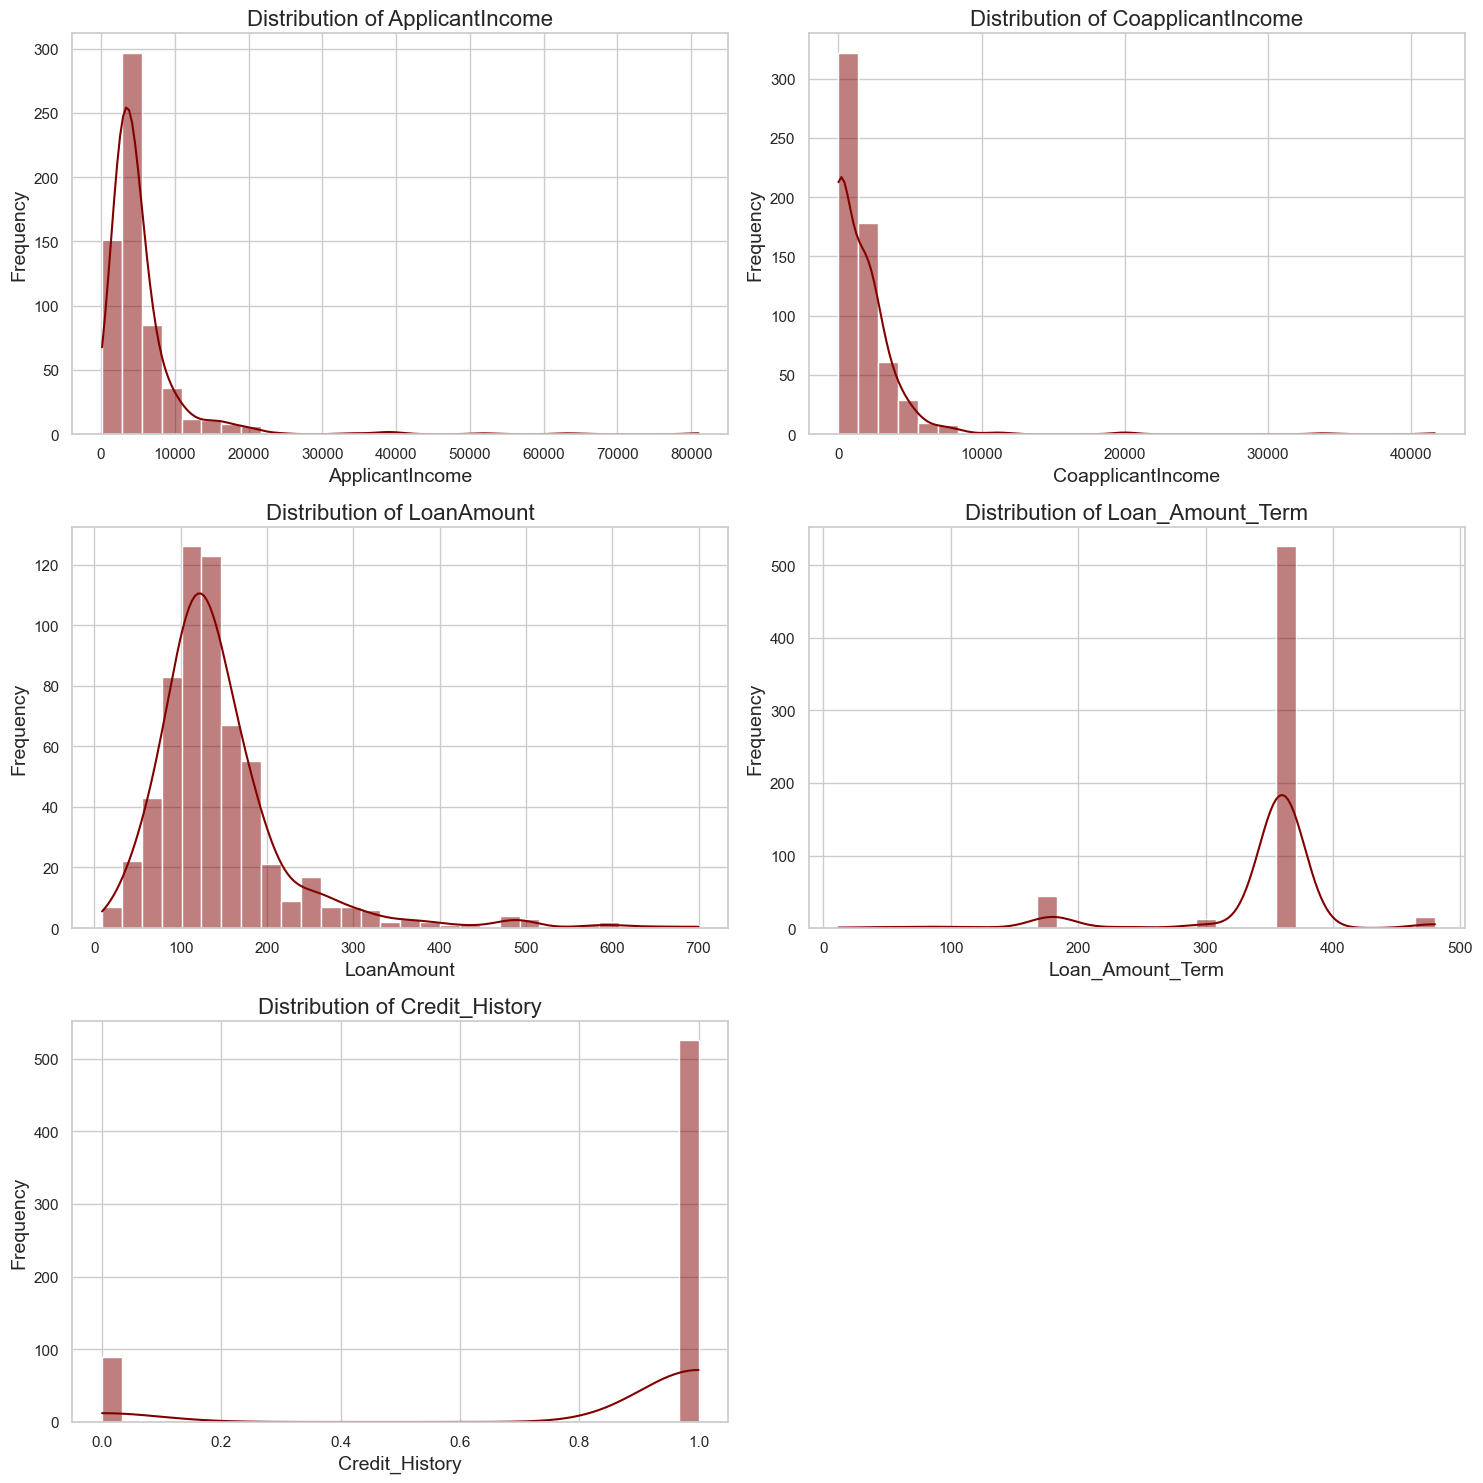

In [80]:
#Plotting Numerical data

# Set the style for the plots
sns.set(style="whitegrid")

# Define the number of plots per row
plots_per_row = 2

# Calculate the number of rows needed
num_rows = len(loan_num.columns) // plots_per_row + int(len(loan_num.columns) % plots_per_row > 0)

# Create a figure with multiple subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Iterate through each numerical feature and plot the histogram
for idx, col in enumerate(loan_num.columns):
    sns.histplot(loan_num[col], bins=30, kde=True, color="maroon", ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}', fontsize=16)
    axes[idx].set_xlabel(col, fontsize=14)
    axes[idx].set_ylabel('Frequency', fontsize=14)
    axes[idx].grid(True)

# Remove any empty subplots
for j in range(len(loan_num.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

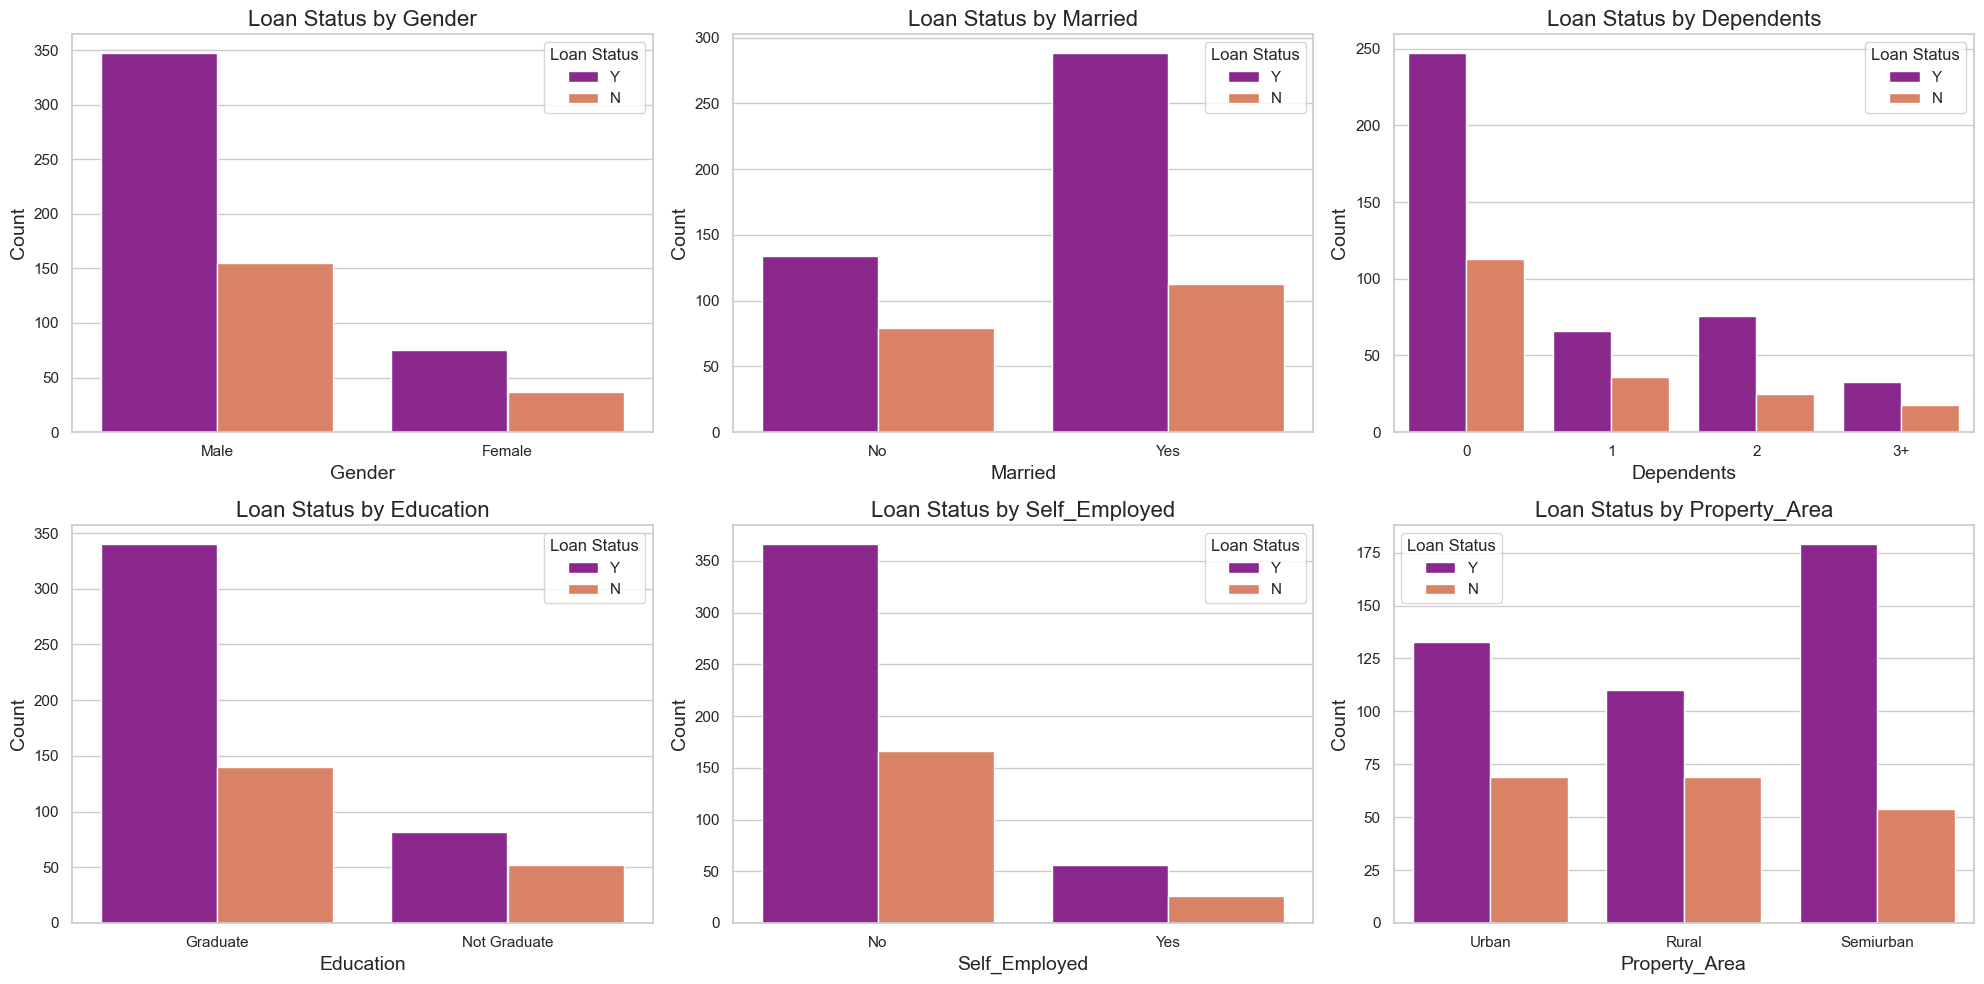

In [81]:
#Plotting Categorical data

# Set the style for the plots
sns.set(style="whitegrid")

# Define the number of plots per row
plots_per_row = 3

# Calculate the number of rows needed
num_rows = len(cat[:-1]) // plots_per_row + int(len(cat[:-1]) % plots_per_row > 0)

# Create a figure with multiple subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Iterate through each categorical feature and plot the count plot
for idx, i in enumerate(cat[:-1]):
    sns.countplot(x=i, hue='Loan_Status', data=train_df, palette='plasma', ax=axes[idx])
    axes[idx].set_title(f'Loan Status by {i}', fontsize=16)
    axes[idx].set_xlabel(i, fontsize=14)
    axes[idx].set_ylabel('Count', fontsize=14)
    axes[idx].legend(title='Loan Status')

# Remove any empty subplots
for j in range(len(cat[:-1]), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [82]:
# Define the mapping dictionary for categorical to numerical conversion
to_numeric = {
    'Male': 1, 'Female': 2,
    'Yes': 1, 'No': 2,
    'Graduate': 1, 'Not Graduate': 2,
    'Urban': 3, 'Semiurban': 2, 'Rural': 1,
    'Y': 1, 'N': 0,
    '3+': 3
}

# Apply the mapping to both datasets
train_df = train_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)
test_df = test_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)

# Convert the 'Dependents' column to numeric, handling any non-numeric values
train_df['Dependents'] = pd.to_numeric(train_df['Dependents'], errors='coerce')
test_df['Dependents'] = pd.to_numeric(test_df['Dependents'], errors='coerce')

# Check the manipulated datasets for validation
print(f"Training set (rows, cols): {train_df.shape}")
print(f"Testing set (rows, cols): {test_df.shape}")

print(train_df.info())
print(test_df.info())

Training set (rows, cols): (614, 12)
Testing set (rows, cols): (367, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11

C:\Users\adria\AppData\Local\Temp\ipykernel_29324\3129298522.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_df = train_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)
C:\Users\adria\AppData\Local\Temp\ipykernel_29324\3129298522.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_df = test_df.applymap(lambda label: to_numeric.get(label) if label in to_numeric else label)


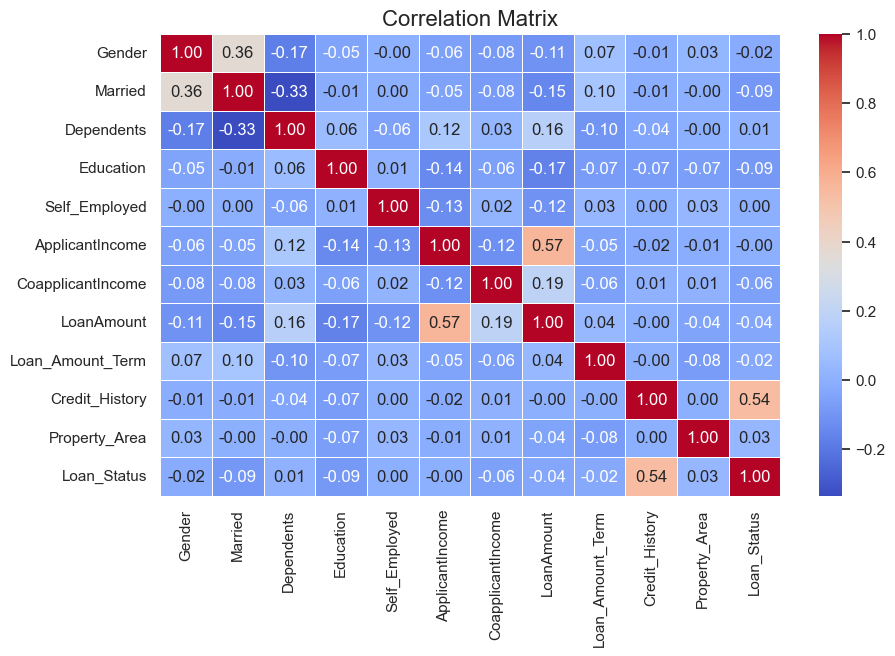

In [83]:
# Generate the correlation matrix
corr_matrix = train_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [86]:
#Machine Learning Model

# Split the data into features (X) and target (y)
X = train_df.drop('Loan_Status', axis=1)
y = train_df['Loan_Status']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
X_train[['LoanAmount', 'ApplicantIncome']] = scaler.fit_transform(X_train[['LoanAmount', 'ApplicantIncome']])
X_val[['LoanAmount', 'ApplicantIncome']] = scaler.transform(X_val[['LoanAmount', 'ApplicantIncome']])

# Define the models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Logistic Regression": LogisticRegression(max_iter=200)
}

# Train and evaluate the models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Model: {name}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("\n" + "="*60 + "\n")
    
# Create a DataFrame for the accuracy results
accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])

# Print the accuracy results
print("Conclusion Table: Model Accuracy Comparison")
print(accuracy_df)

Model: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.56      0.56        43
           1       0.77      0.78      0.77        80

    accuracy                           0.70       123
   macro avg       0.67      0.67      0.67       123
weighted avg       0.70      0.70      0.70       123

Accuracy: 0.6991869918699187


Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.44      0.58        43
           1       0.76      0.95      0.84        80

    accuracy                           0.77       123
   macro avg       0.79      0.70      0.71       123
weighted avg       0.78      0.77      0.75       123

Accuracy: 0.7723577235772358


Model: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.47      0.58        43
           1       0.76      0.93      0.84      

C:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\adria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Accuracy: 0.7886178861788617


Conclusion Table: Model Accuracy Comparison
                 Model  Accuracy
0        Decision Tree  0.707317
1        Random Forest  0.772358
2              XGBoost  0.780488
3  Logistic Regression  0.788618


Logistic Regression Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Validation Accuracy of Logistic Regression: 0.7886178861788617


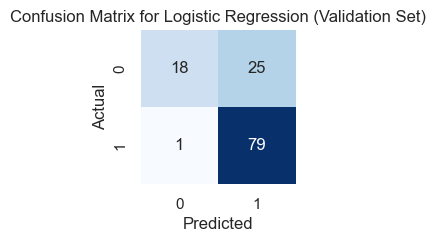

Predictions saved to C:\Users\adria\OneDrive\Documents\predicted_loan_status.csv
Predictions on Test Set:
     Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0         1        1           0          1              2             5720   
1         1        1           1          1              2             3076   
2         1        1           2          1              2             5000   
3         1        1           2          1              2             2340   
4         1        2           0          2              2             3276   
..      ...      ...         ...        ...            ...              ...   
362       1        1           3          2              1             4009   
363       1        1           0          1              2             4158   
364       1        2           0          1              2             3250   
365       1        1           0          1              2             5000   
366       1        2     

C:\Users\adria\AppData\Local\Temp\ipykernel_29324\1324871277.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Loan_Status_Predicted', data=test_df_with_predictions, palette='viridis')


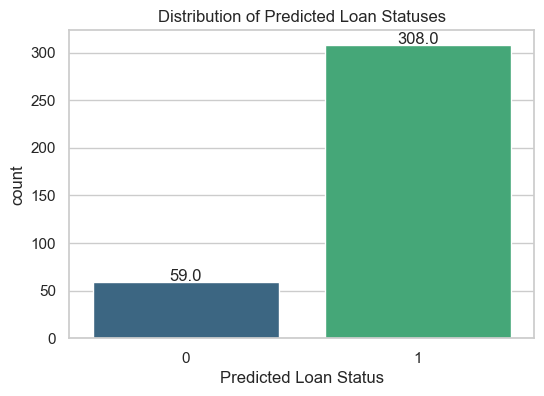

In [85]:
#Data Prediction on Test Dataset

# Handle missing values by imputing
imputer = SimpleImputer(strategy='mean')  # You can change the strategy to 'median', 'most_frequent', or 'constant'

# Split the training data into features (X) and target (y)
X = train_df.drop('Loan_Status', axis=1)
y = train_df['Loan_Status']

# Impute missing values in the training set
X = imputer.fit_transform(X)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = test_df  # Assuming the test set is already defined

# Impute missing values in the test set
X_test = imputer.transform(X_test)

# Scale the numerical features in the test set
X_test = scaler.transform(X_test)

# Define and train the Logistic Regression model
LR = LogisticRegression(max_iter=200)
LR.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = LR.predict(X_val)

# Evaluate on the validation set
print("Logistic Regression Validation Classification Report:")
print(classification_report(y_val, y_pred_val))
LR_accuracy_val = accuracy_score(y_val, y_pred_val)
print('Validation Accuracy of Logistic Regression:', LR_accuracy_val)

# Plot confusion matrix for the validation set
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(2, 2))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression (Validation Set)')
plt.show()

# Predict on the test set
y_pred_test = LR.predict(X_test)

# Create a DataFrame to show the predictions
test_df_with_predictions = test_df.copy()
test_df_with_predictions['Loan_Status_Predicted'] = y_pred_test

# Save the predictions to a local path
save_path = r'C:\Users\adria\OneDrive\Documents\predicted_loan_status.csv'
test_df_with_predictions.to_csv(save_path, index=False)
print(f"Predictions saved to {save_path}")

# Display the predictions
print("Predictions on Test Set:")
print(test_df_with_predictions)

# Plot the distribution of the predicted loan statuses
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Loan_Status_Predicted', data=test_df_with_predictions, palette='viridis')
plt.xlabel('Predicted Loan Status')
plt.title('Distribution of Predicted Loan Statuses')

# Add the data values on the plot
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.show()